In [1]:
import pandas as pd
%pylab inline

train = pd.read_json("data/train.json")
print(train.shape)

Populating the interactive namespace from numpy and matplotlib
(4040, 32)


In [2]:
from nltk.corpus import stopwords # Import the stop word list
stop = stopwords.words('english')

In [3]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = PorterStemmer()
snowball = SnowballStemmer("english")
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [4]:
stem_tokens(["communication"], snowball)

[u'communic']

In [5]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


In [6]:
class SnowballTokenizer(object):
    def __init__(self):
        self.wnl = SnowballStemmer("english")
    def __call__(self, doc):
        return [self.wnl.stem(t) for t in word_tokenize(doc)]

In [7]:
l = LemmaTokenizer()
l("communication")

['communication']

In [8]:
s = SnowballTokenizer()
s("communication")

[u'communic']

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

countvec = CountVectorizer(stop_words=stop,
                           ngram_range=(1, 2),
                           min_df=(0.001), 
                           max_df=(0.9), 
                           tokenizer=SnowballTokenizer())

In [10]:
from sklearn import cross_validation as cv
from sklearn import pipeline as pipe

X_text = countvec.fit_transform(train["request_text_edit_aware"])

/home/dylan/GitHub/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
X_text.shape

(4040, 981)

In [12]:
train.columns

Index([u'giver_username_if_known',
       u'number_of_downvotes_of_request_at_retrieval',
       u'number_of_upvotes_of_request_at_retrieval', u'post_was_edited',
       u'request_id', u'request_number_of_comments_at_retrieval',
       u'request_text', u'request_text_edit_aware', u'request_title',
       u'requester_account_age_in_days_at_request',
       u'requester_account_age_in_days_at_retrieval',
       u'requester_days_since_first_post_on_raop_at_request',
       u'requester_days_since_first_post_on_raop_at_retrieval',
       u'requester_number_of_comments_at_request',
       u'requester_number_of_comments_at_retrieval',
       u'requester_number_of_comments_in_raop_at_request',
       u'requester_number_of_comments_in_raop_at_retrieval',
       u'requester_number_of_posts_at_request',
       u'requester_number_of_posts_at_retrieval',
       u'requester_number_of_posts_on_raop_at_request',
       u'requester_number_of_posts_on_raop_at_retrieval',
       u'requester_number_of_subr

In [12]:
# other features
features_selected=[
    "requester_account_age_in_days_at_request",
    "requester_days_since_first_post_on_raop_at_request",
    "requester_number_of_comments_at_request",
    "requester_number_of_comments_in_raop_at_request",
    "requester_number_of_posts_at_request",
    "requester_number_of_posts_on_raop_at_request",
    "requester_number_of_subreddits_at_request",
    "requester_upvotes_minus_downvotes_at_request",
    "requester_upvotes_plus_downvotes_at_request"]
num_features = train[features_selected]

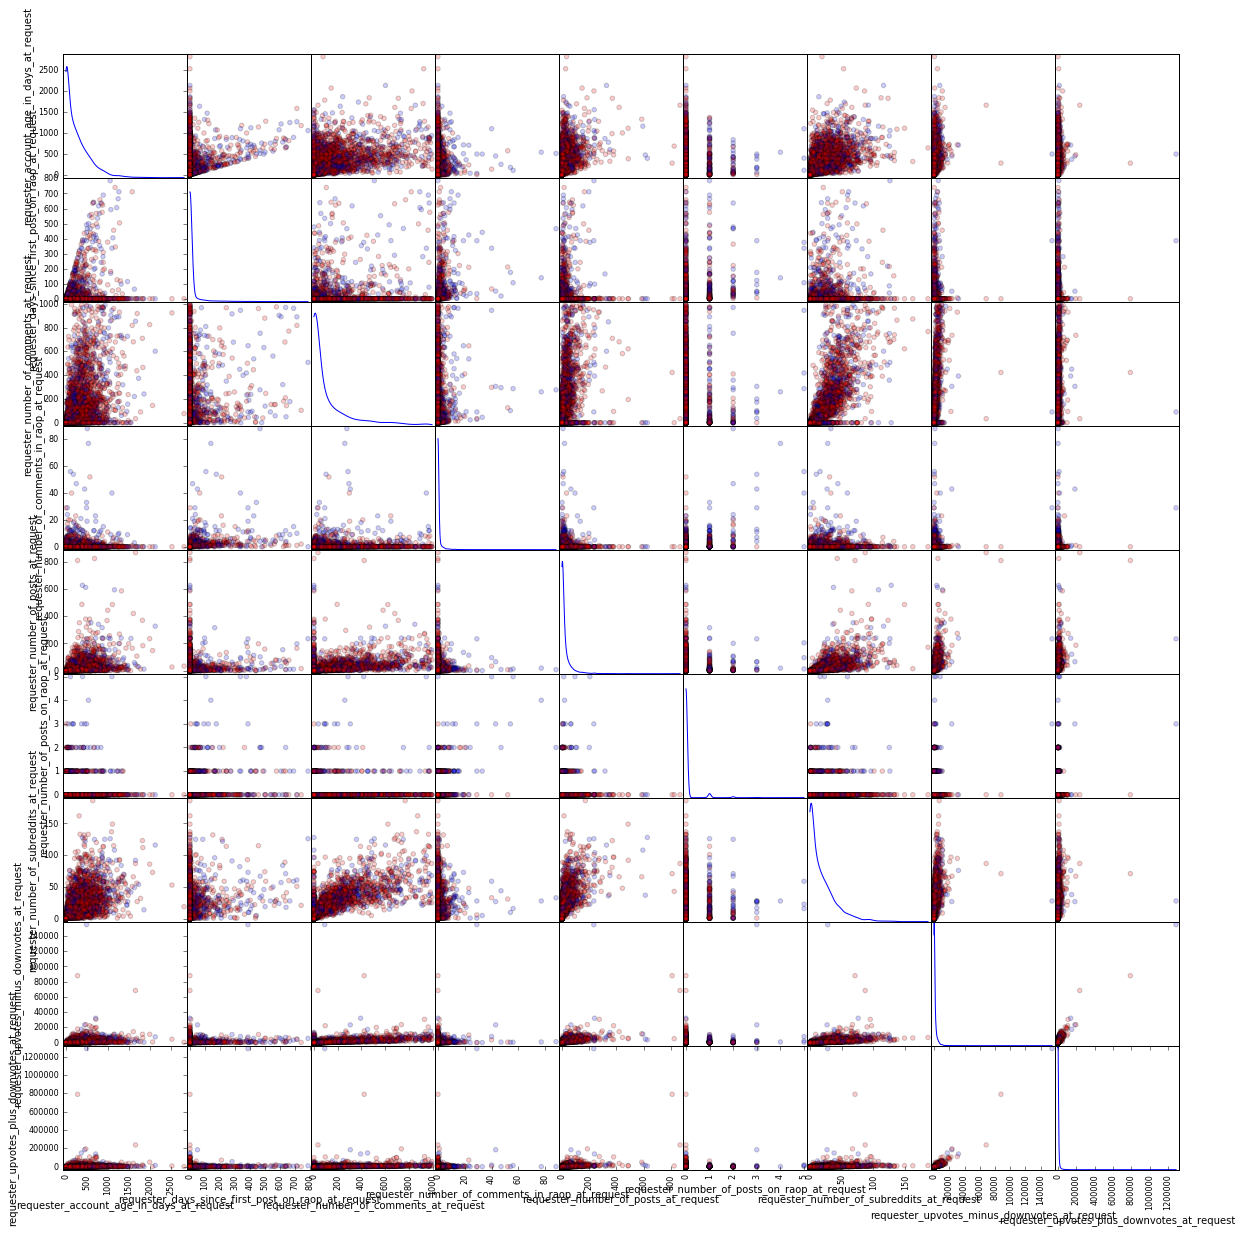

In [14]:
from pandas.tools.plotting import scatter_matrix
color_wheel = {True: "blue", False:"red"}
scatter_matrix(num_features, c=train["requester_received_pizza"].apply(lambda x:color_wheel[x]), alpha=0.2, figsize=(20, 20), 
               diagonal='kde', marker='o')
plt.show()

In [13]:
X_num = np.asarray(num_features)

In [14]:
X_text = X_text.todense().astype(np.float64)

In [15]:
subs = [' '.join(v) for v 
        in train["requester_subreddits_at_request"].tolist()]
# subreddit one hot encoded
sub_vec = CountVectorizer(binary=True, min_df=0.005, max_df=0.9)
X_subreddit = sub_vec.fit_transform(subs)
X_subreddit = X_subreddit.todense().astype(np.float64)

In [16]:
title_vec = CountVectorizer(min_df=0.005, max_df=0.9, ngram_range=(1,2), tokenizer=SnowballTokenizer())
X_title = title_vec.fit_transform(train['request_title']).todense().astype(np.float64)

In [17]:
print("{} {}").format(X_text.shape, X_text.dtype)
print("{} {}").format(X_subreddit.shape, X_subreddit.dtype)
print("{} {}").format(X_num.shape, X_num.dtype)
print("{} {}").format(X_title.shape, X_title.dtype)

(4040, 981) float64
(4040, 488) float64
(4040, 9) float64
(4040, 631) float64


In [18]:
X_all = np.hstack((X_text, X_subreddit, X_num, X_title))
X_all.shape

(4040, 2109)

In [19]:
from sklearn import feature_selection as select
from sklearn import preprocessing as prep
from sklearn import linear_model
processing  = pipe.Pipeline([
    ('remover', select.VarianceThreshold()),
    ('scaler', prep.StandardScaler()),
    ('logres', 
     linear_model.LogisticRegression(class_weight='balanced'))
])

In [20]:
y = train['requester_received_pizza']

In [23]:
cv.cross_val_score(processing, X_text, y)

array([ 0.60682493,  0.60029718,  0.57800892])

In [24]:
cv.cross_val_score(processing, X_all, y)

array([ 0.60237389,  0.63372957,  0.63521545])

In [25]:
processing.fit(X_all,y)

Pipeline(steps=[('remover', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logres', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

# Submission 1 (LogRes + All)
## Loading test features

In [26]:
test = pd.read_json("data/test.json")
print(test.shape)

(1631, 17)


In [27]:
X_test_text = countvec.transform(
    test["request_text_edit_aware"]).todense().astype(np.float64)

In [28]:
X_test_num = np.asarray(test[features_selected])

In [29]:
subs = [' '.join(v) for v 
        in test["requester_subreddits_at_request"].tolist()]
X_test_subreddit = sub_vec.transform(subs)
X_test_subreddit = X_test_subreddit.todense().astype(np.float64)

In [30]:
X_test_title = title_vec.transform(test['request_title']).todense().astype(np.float64)

In [31]:
print("{} {}").format(X_test_text.shape, X_text.dtype)
print("{} {}").format(X_test_subreddit.shape, X_subreddit.dtype)
print("{} {}").format(X_test_num.shape, X_num.dtype)
print("{} {}").format(X_test_title.shape, X_test_title.dtype)

(1631, 981) float64
(1631, 488) float64
(1631, 9) float64
(1631, 631) float64


In [32]:
X_test_all = np.hstack((X_test_text, X_test_subreddit, X_test_num, X_test_title))
X_test_all.shape

(1631, 2109)

In [360]:
predictions_test = processing.predict(X_test_all).reshape((1631, 1)).astype(np.int8)
ids = test[["request_id"]].as_matrix()
submission_1 = np.hstack((ids, predictions_test))
submission_1 = pd.DataFrame(data=submission_1,    # get only the values of the positive class
                            index=submission_1[:,0],    # 1st column as index too
                            columns=["request_id","requester_received_pizza"])
submission_1.to_csv('submissions/pizza-submission-1.(logres).txt',
                   index=False, dtype={'request_id':np.int64, 'requester_received_pizza':np.float64})

# Decision Tree Classifiers
Decision trees are constructed by choosing a feature at a given iteration to split. Splitting is done by finding a categorical value of an attribute that "splits" the dataset the cleanest. After an "exit" condition is met, modern decision tree classifiers prune branches of the tree to "regularize the tree".

(http://www.cs.waikato.ac.nz/~eibe/pubs/multiway.pdf)

## Mathematical Formulation
(http://scikit-learn.org/stable/modules/tree.html#mathematical-formulation)

Given training vectors $x_i \in R^n, i=1,..., l$ and a label vector $y \in R^l$, a decision tree recursively partitions the space such that the samples with the same labels are grouped together.

Let the data at node m be represented by $Q$. For each candidate split $\theta = (j, t_m)$ consisting of a feature j and threshold $t_m$, partition the data into $Q_{left}(\theta)$ and $Q_{right}(\theta)$ subsets

$$
\begin{align}
Q_{left}(\theta) &= {(x, y) | x_j <= t_m} \\
Q_{right}(\theta) &= Q \setminus Q_{left}(\theta)
\end{align}
$$

The impurity at m is computed using an impurity function $H()$, the choice of which depends on the task being solved (classification or regression)

$$G(Q, \theta) = \frac{n_{left}}{N_m} H(Q_{left}(\theta)) + \frac{n_{right}}{N_m} H(Q_{right}(\theta))$$

Select the parameters that minimises the impurity

$$\theta^* = \operatorname{argmin}_\theta G(Q, \theta)$$

Recurse for subsets $Q_{left}(\theta^*)$ and $Q_{right}(\theta^*)$ until the maximum allowable depth is reached, $N_m < \min_{samples}$ or $N_m = 1$.

Let's study an example of an impurity function, cross entropy:
$$
H(X_m) = - \sum_k p_{mk} \log(p_{mk})
$$


In [25]:
from scipy import stats
stats.entropy((100,100))

0.69314718055994529

In [42]:
stats.entropy((199*0.2,1*0.8))

0.096886582171572783

In [41]:
stats.entropy((100*(0.2),100*(0.8)))

0.50040242353818787

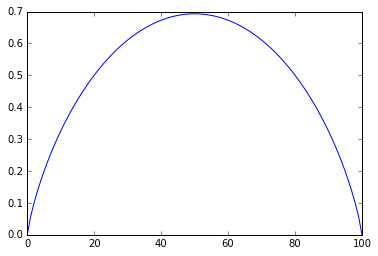

In [29]:
vals = []
for v in np.linspace(0,100,num=101):
    vals.append(stats.entropy((v, 100-v)))
plt.plot(vals)

In short, when there is an even split, then the impurity is maximal. What we want is the cleanest possible split, that is, the impurity is minimal (pure!)

An extension to information gain is information gain ratio, where the bias towards multi-class and large splits are reduced. https://en.wikipedia.org/wiki/Information_gain_ratio

In [34]:
from sklearn import feature_selection as select
from sklearn import preprocessing as prep
from sklearn import tree
processing  = pipe.Pipeline([
    ('remover', select.VarianceThreshold()),
    ('scaler', prep.StandardScaler()),
    ('dt', 
     tree.DecisionTreeClassifier(
                class_weight='balanced'))
])
cv.cross_val_score(processing, X_all, y)

array([ 0.64614243,  0.65750371,  0.64190193])

In [36]:
cv.cross_val_score(processing, X_text, y)

array([ 0.60682493,  0.60029718,  0.57800892])

In [35]:
processing.fit(X_all, y)

Pipeline(steps=[('remover', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dt', DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [40]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydot
def print_tree(dt):
    dot_data = StringIO(dt)  
    tree.export_graphviz(dt, out_file=dot_data)  
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

Couldn't import dot_parser, loading of dot files will not be possible.


In [36]:
processing.steps[2][1].tree_.node_count

1125

In [37]:
from sklearn import feature_selection as select
from sklearn import preprocessing as prep
from sklearn import tree
processing  = pipe.Pipeline([
    ('remover', select.VarianceThreshold()),
    ('scaler', prep.StandardScaler()),
    ('dt', 
     tree.DecisionTreeClassifier(
                class_weight='balanced',
                max_depth=2, criterion="entropy"))
])
cv.cross_val_score(processing, X_all, y)

array([ 0.41172107,  0.41381872,  0.3922734 ])

In [38]:
processing.fit(X_all, y)

Pipeline(steps=[('remover', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dt', DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=2, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [43]:
processing.steps[2][1].tree_.node_count

7

# Ensemble Classifiers
(https://people.cs.pitt.edu/~milos/courses/cs2750-Spring04/lectures/class23.pdf)
## Bagging Ensemble
Bagging is also known as "Bootstrap Aggregating". It is a meta-estimation method that samples with replacement the training set and trains different classifiers for each. It reduces the variance of the dataset by attempting to artificially create more data, as well as averaging out the results for each sample.

For bagging, strong classifiers are proven to be better. An example of bagging is Random Forests.

(http://scikit-learn.org/stable/modules/ensemble.html#bagging-meta-estimator)

In [45]:
from sklearn import feature_selection as select
from sklearn import preprocessing as prep
from sklearn import ensemble
processing  = pipe.Pipeline([
    ('remover', select.VarianceThreshold()),
    ('scaler', prep.StandardScaler()),
    ('rf', 
     ensemble.RandomForestClassifier(
                class_weight='balanced',
                criterion="entropy"))
])
cv.cross_val_score(processing, X_all, y)

array([ 0.74183976,  0.75037147,  0.73922734])

In [68]:
processing  = pipe.Pipeline([
    ('remover', select.VarianceThreshold()),
    ('scaler', prep.StandardScaler()),
    ('rf', 
     ensemble.RandomForestClassifier(
                n_estimators=100, 
                class_weight='balanced', 
                criterion="entropy"))
])
# cv.cross_val_score(processing, X_all, y)
cv.cross_val_score(processing, X_all, y,scoring='log_loss')

array([-0.53143155, -0.53114445, -0.53206779])

## Boosting
Boosting is a family of techniques that sequentially trains classifiers on the mistakes of the previous models. Samples with correct predictions are weighted less and the incorrect samples are weighted more, causing the newer models to try and correct the higher weighted samples.

For boosting, weak classifiers are used.

In [67]:
processing  = pipe.Pipeline([
    ('remover', select.VarianceThreshold()),
    ('scaler', prep.StandardScaler()),
    ('rf', 
     ensemble.GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
                           max_depth=2))
])
# cv.cross_val_score(processing, X_all, y)
cv.cross_val_score(processing, X_all, y,scoring='log_loss')

array([-0.55884746, -0.56269369, -0.57571756])

In [48]:
processing  = pipe.Pipeline([
    ('remover', select.VarianceThreshold()),
    ('scaler', prep.StandardScaler()),
    ('rf', 
     ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                           max_depth=2))
])
cv.cross_val_score(processing, X_all, y)

array([ 0.70029674,  0.71396731,  0.70802377])

In [66]:
processing  = pipe.Pipeline([
    ('remover', select.VarianceThreshold()),
    ('scaler', prep.StandardScaler()),
    ('rf', 
     ensemble.GradientBoostingClassifier(
                n_estimators=100, learning_rate=0.1,
                max_depth=3, subsample=0.5))
])
# cv.cross_val_score(processing, X_all, y)
cv.cross_val_score(processing, X_all, y,scoring='log_loss')

array([-0.54442096, -0.5319685 , -0.54811521])

In [58]:
processing.fit(X_all, y)

Pipeline(steps=[('remover', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False))])

In [46]:
from sklearn import metrics

processing.fit(X_all, y)

Pipeline(steps=[('remover', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logres', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [49]:
preds = processing.predict_proba(X_all[:5])
preds

array([[  9.99999989e-01,   1.10036433e-08],
       [  9.95121668e-01,   4.87833179e-03],
       [  9.95851200e-01,   4.14879977e-03],
       [  9.78771438e-01,   2.12285624e-02],
       [  1.00000000e+00,   1.30548111e-13]])

In [50]:
metrics.log_loss(y[:5], preds)

0.0061009679030655274

# Submission 2 (Gradient Boosting)

In [59]:
predictions_test = processing.predict(X_test_all).reshape((1631, 1)).astype(np.int8)
ids = test[["request_id"]].as_matrix()
submission_2 = np.hstack((ids, predictions_test))
submission_2 = pd.DataFrame(data=submission_2,    # get only the values of the positive class
                            index=submission_2[:,0],    # 1st column as index too
                            columns=["request_id","requester_received_pizza"])
submission_2.to_csv('submissions/pizza-submission-2.(gboost).txt',
                   index=False, dtype={'request_id':np.int64, 'requester_received_pizza':np.float64})

# Submission 3 (Bagging Random Forest)

In [63]:
processing  = pipe.Pipeline([
    ('remover', select.VarianceThreshold()),
    ('scaler', prep.StandardScaler()),
    ('rf', 
     ensemble.RandomForestClassifier(n_estimators=100, class_weight='balanced', criterion="entropy"))
])
processing.fit(X_all, y)
predictions_test = processing.predict(X_test_all).reshape((1631, 1)).astype(np.int8)
ids = test[["request_id"]].as_matrix()
submission_3 = np.hstack((ids, predictions_test))
submission_3 = pd.DataFrame(data=submission_3,    # get only the values of the positive class
                            index=submission_3[:,0],    # 1st column as index too
                            columns=["request_id","requester_received_pizza"])
submission_3.to_csv('submissions/pizza-submission-3.(RF).txt',
                   index=False, dtype={'request_id':np.int64, 'requester_received_pizza':np.float64})